## Seq2Seq의 Encoder로 뉴스기사 토픽 예측

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## 도입전 기본 처리

In [6]:
# 데이터 불러오기
reuters = keras.datasets.reuters
(train_text, train_topic), (test_text, test_topic) = reuters.load_data()

2121728/2110848 [==============================] - 0s 0us/step


In [7]:
# 데이터 크기 출력
print(train_text.shape)
print(train_topic.shape)
print(test_text.shape)
print(test_topic.shape)

(8982,)
(8982,)
(2246,)
(2246,)


In [8]:
# 데이터 타입 출력
print(train_text.dtype, test_text.dtype)
print(train_topic.dtype, test_topic.dtype)

object object
int64 int64


<BarContainer object of 8982 artists>

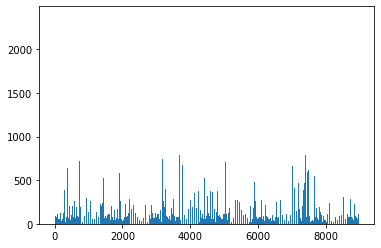

In [9]:
#train_text에서 각 원소의 길이를 y축으로 bar plot 그리기
plt.bar(range(len(train_text)), [len(text) for text in train_text])

## 전처리

In [10]:
# train_text, test_text에서 등장한 정수 알아보기
all_words = set([word for text in train_text for word in text]) | set([word for text in test_text for word in text])

In [11]:
print(sorted(all_words)[:5])
print(sorted(all_words)[-5:])

[1, 2, 4, 5, 6]
[30977, 30978, 30979, 30980, 30981]


In [12]:
# train_text와 test_text를 BOW형태로 변경
train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_text, value = 0)
test_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_text, value = 0)

In [13]:
(train_bow_text.shape, test_bow_text.shape)

((8982, 2376), (2246, 1032))

In [14]:
# train과 test에 나온 word의 count 측정
import collections
word_count = collections.Counter()
for text in train_text:
    word_count.update(text)
for text in test_text:
    word_count.update(text)

word_count.most_common(10)

[(4, 82723),
 (5, 42393),
 (6, 40350),
 (7, 33157),
 (8, 29978),
 (9, 29956),
 (10, 29581),
 (11, 20141),
 (12, 16668),
 (13, 15224)]

In [15]:
# word_count를 이용해서 n번 이하로 나온 word를 삭제하여 train, test 구성
def cut_by_count(texts, n):
    return np.array([[word for word in text if word_count[word] >= n] for text in texts])

In [16]:
train_cut_text = cut_by_count(train_text, 20)
test_cut_text = cut_by_count(test_text, 20)

In [17]:
train_cut_text.shape, test_cut_text.shape

((8982,), (2246,))

In [19]:
# bow 형태로 변환 후 width 확인
train_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text, value=0)
test_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text, value=0)

In [20]:
train_cut_bow_text.shape, test_cut_bow_text.shape

((8982, 2266), (2246, 995))

In [22]:
# train_text/test_text에 길이 제한을 주고 bow를 생성
train_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(train_text, value=0, maxlen=200)
test_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(test_text, value=0, maxlen=200)

In [23]:
train_cut_bow_text2.shape, test_cut_bow_text2.shape

((8982, 200), (2246, 200))

In [24]:
# topic을 onehot encoding으로 변경
np.unique(train_topic)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)